## Random Model Editing: How does performance change when the model is randomly changed rather than using an image to guide the edit?

In [1]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
from datetime import datetime
import pandas as pd

In [26]:
# Local imports
sys.path.insert(0, 'src')
from test import predict
from parse_config import ConfigParser
import datasets.datasets as module_data

import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from trainer.editor import Editor

from utils import read_json, read_lists, informal_log, list_to_dict, write_lists, write_json, ensure_files, ensure_dir
from utils.model_utils import prepare_device
from utils.results_to_csv import store_csv
from utils.edit_utils import prepare_edit_data #, get_target_weights
from utils.knn_utils import knn, analyze_knn, load_and_analyze_knn
from utils.df_utils import load_and_preprocess_csv, summary_histogram
from utils.visualizations import histogram

from edit_knn import main as edit

# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

### Outline

1. given a path of keys and values
2. perform an edit for each key and value
    a. save the weight difference in a list
3. after all edits, stack the tensors and take the mean and std

In [3]:
# Define constants, paths
class_list_path = os.path.join('metadata', 'cinic-10', 'class_names.txt')
# Define constants, paths
config_path = 'configs/copies/edit_experiments/cinic10_imagenet-random_edit.json'
class_list_path = 'metadata/cinic-10/class_names.txt'

analyze_in_edit = False
sort_type = 'softmax'

In [4]:
timestamp = datetime.now().strftime(r'%m%d_%H%M%S')
paths_timestamp = '0126_161209'


In [29]:
# # Load config file
# config_dict = read_json(config_path)
# # Load class list and obtain target class idx
# class_list = read_lists(class_list_path)
# class_idx_dict = list_to_dict(class_list)

# n_select = 100

# # Set K
# K = config_dict['editor']['K']

# device, device_ids = prepare_device(config_dict['n_gpu'])

csv_path = 'saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0131_134915/results_table.csv'
save_visualizations_dir = os.path.join(os.path.dirname(csv_path), 'graphs')
ensure_dir(save_visualizations_dir)

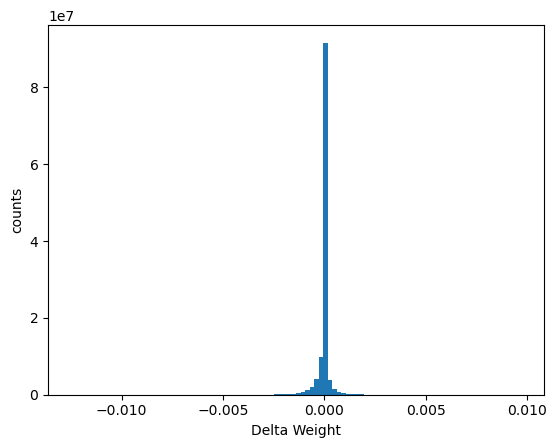

In [65]:
histogram(
    data=data.detach().cpu().numpy(),
    n_bins=100,
    xlabel='Delta Weight',
    ylabel='counts')

### Analyze the results from random model editing

In [30]:
# Before calling this, call python src/utils/results_to_csv.py with the trial_paths_path

df = load_and_preprocess_csv(
    csv_path=csv_path,
    drop_duplicates=['ID'])
print("{} rows in data frame".format(len(df)))

100 rows in data frame


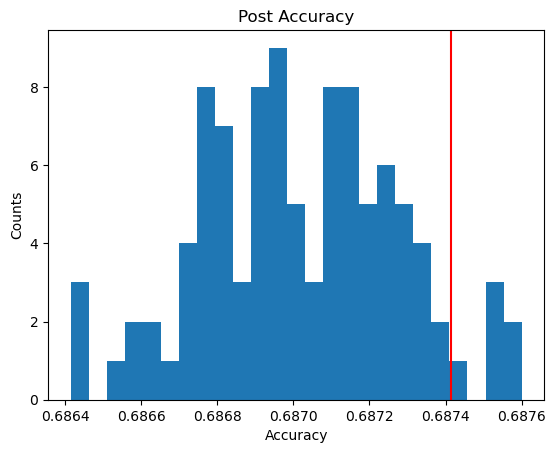

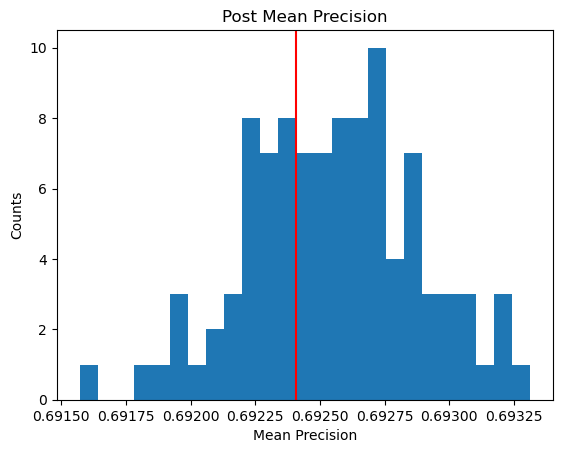

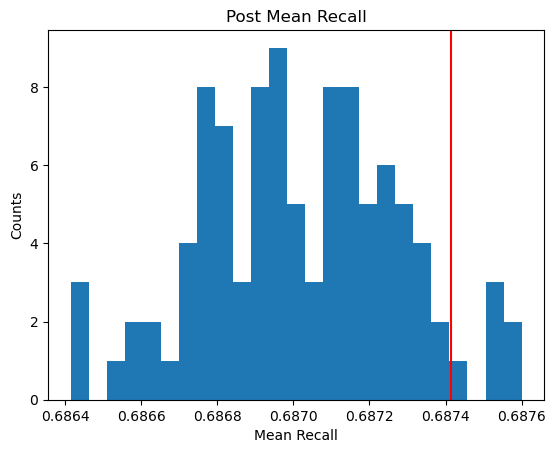

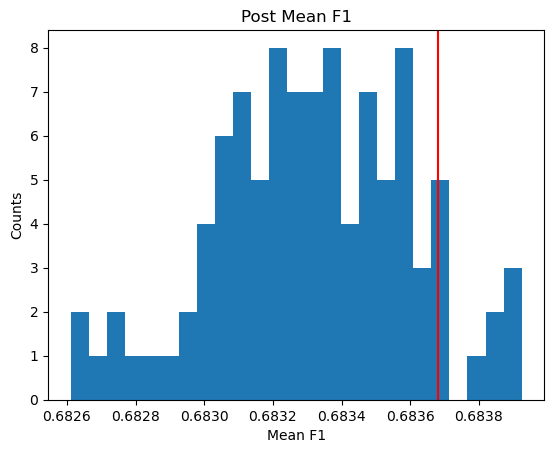

In [31]:
metrics = [['{} Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1']]

summary_histogram(
    df_=df,
    metrics=metrics,
    n_bins=25,
    save_dir=save_visualizations_dir)
    

#### Pretend there is a "target class" and analyze recall

[0.00285714 0.00242857 0.00214285 0.00414286 0.00328571 0.00214286
 0.003      0.00357143 0.00157142 0.00357143 0.004      0.006
 0.00371429 0.00257143 0.00414285 0.00414286 0.00528571 0.003
 0.004      0.00371428 0.00242857 0.00371429 0.00428571 0.00385714
 0.00257143 0.00385714 0.00257143 0.00614286 0.00257143 0.00257143
 0.00414285 0.00285714 0.00471428 0.003      0.00214286 0.00442857
 0.002      0.00371429 0.00485714 0.00342857 0.00557142 0.00428572
 0.00557143 0.00314285 0.00414285 0.00414285 0.00214285 0.00442857
 0.008      0.00285714 0.00414285 0.00271428 0.00271428 0.00342857
 0.00271429 0.00371428 0.00514285 0.004      0.00371429 0.00385714
 0.003      0.00142857 0.003      0.00342857 0.00414285 0.00357143
 0.00357143 0.00285714 0.00357143 0.00342857 0.00328571 0.00485714
 0.00228572 0.00471428 0.00485714 0.00442857 0.00657143 0.00214286
 0.00514286 0.00328572 0.00342857 0.00357143 0.002      0.00257143
 0.00642857 0.00342857 0.003      0.00271428 0.00628571 0.005
 0.003    

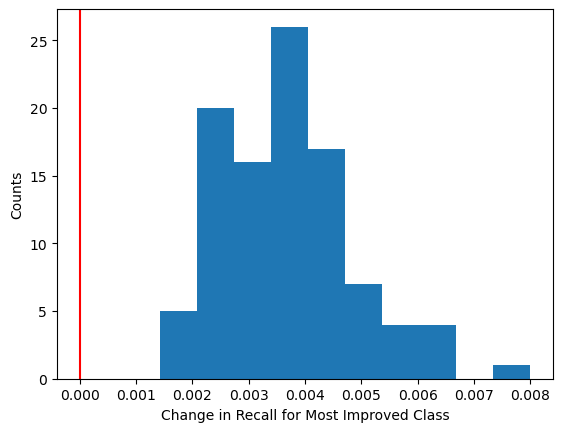

In [50]:
post_per_class_recalls = df['Post Per-Class Recall'].to_numpy()
post_per_class_recalls = np.stack(post_per_class_recalls, axis=0)

pre_per_class_recalls = df['Pre Per-Class Recall'].to_numpy()
pre_per_class_recalls = np.stack(pre_per_class_recalls, axis=0)

differences = post_per_class_recalls - pre_per_class_recalls
max_diff = np.amax(differences, axis=1)
max_diff_idxs = np.argmax(differences, axis=1)
print(max_diff, max_diff_idxs)
print(differences[:10])
delta_recalls = []
histogram(
    data=max_diff,
    n_bins=10,
    xlabel='Change in Recall for Most Improved Class',
    ylabel='Counts',
    marker=0.0)
